In [ ]:
# read the data from the Fake.csv and True.csv files and create training, validation and test sets

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tf_mcc import MCC

In [2]:
from zipfile import ZipFile

def unzip(file_name, final_path):
    with ZipFile(file_name, "r") as zipObj:
        zipObj.extractall(path = final_path)

unzip("dataset/Fake.csv.zip", "dataset/")
unzip("dataset/True.csv.zip", "dataset/")
        

In [3]:
fake = pd.read_csv('dataset/Fake.csv')
true = pd.read_csv('dataset/True.csv')

In [71]:
# true.isnull().any()
# fake.isnull().any()

In [4]:
# remove rows of text with empty strings 
fake = fake.drop(fake[fake.text == " "].index)
true = true.drop(true[true.text == " "].index)

In [5]:
# add binary column that indicates if the news are True (1) or Fake (0) 
fake["classification"] = 0
true["classification"] = 1

In [6]:
# combine the Fake and True dataframes 
frames = [fake, true]
result = pd.concat(frames, ignore_index = True)

In [7]:
result.head(-1)

,title,text,subject,date,classification
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44265,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017",1
44266,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44267,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44268,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1


In [7]:
# generate a random sample (without replacement) of the combined dataframe
# use random_state to make it reproducible
corpus = result.sample(frac = 1, replace = False, random_state = 1234)
corpus.head()

,title,text,subject,date,classification
1220,Comey Might Have Just Made Sure We Don’t End ...,Many of us have been ready to impeach Donald T...,News,"June 8, 2017",0
43761,Exclusive: Cambodia says opposition party coul...,PHNOM PENH (Reuters) - Cambodia s government h...,worldnews,"September 5, 2017",1
24279,Whirlpool's washer war is balancing act for Trump,"Clyde, Ohio (Reuters) - In the middle of Whir...",politicsNews,"October 4, 2017",1
11119,BOOM! TRUMP POLL Numbers Going Up…Up…Up! While...,"Way before the election ever took place, the l...",politics,"Apr 17, 2017",0
29975,U.S. Holocaust museum alarmed over 'hateful sp...,WASHINGTON (Reuters) - The U.S. Holocaust Memo...,politicsNews,"November 22, 2016",1


In [8]:
# split data into training, validation and test set
X_features_names = ["title"]
X_features = corpus[X_features_names].values

X_data = X_features
y_data = corpus["classification"].values


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.4, random_state = 1234)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 1234)

In [10]:
(X_train.shape, y_train.shape)

((26562, 1), (26562,))

In [12]:
# model parameters
vocabulary_size = 10000 # maximum vocabulary size (max_features, maximum number of tokens)
max_len = 250 # sequence length to pad the outputs to
embedding_dim = 16

# create vocab layer
# instantiate the text vectorization layer
vectorize_layer = TextVectorization(max_tokens = vocabulary_size, 
                                    standardize = "lower_and_strip_punctuation", 
                                    output_mode = "int", 
                                    output_sequence_length = max_len)

# build the vocabulary
# vectorization layer that generates a tensor of shape (batch_size, max_len) containing vocabulary indices
vectorize_layer.adapt(X_train)

# vectorize_layer.get_vocabulary()
# vectorize_layer.vocabulary_size()

In [13]:
train_text = vectorize_layer(X_train)
val_text = vectorize_layer(X_val)
test_text = vectorize_layer(X_test)

In [14]:
train_text.shape

TensorShape([26562, 250])

In [15]:
model = Sequential([
    tf.keras.Input(shape = (250,), dtype = tf.int64),
    layers.Embedding(vocabulary_size + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units = 1, activation = "sigmoid") # revise the use of this layer
]
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 250, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [17]:

model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              metrics = [
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  MCC(),
              ],
)


callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)


history = model.fit(
        train_text, y_train,
        validation_data = (val_text, y_val),
        epochs = 20,
        callbacks = [callback],
)

Epoch 1/20
831/831 [==============================] - 5s 4ms/step - loss: 0.6783 - binary_accuracy: 0.6223 - precision: 0.8666 - recall: 0.2545 - mcc: 0.3129 - val_loss: 0.6467 - val_binary_accuracy: 0.7597 - val_precision: 0.9895 - val_recall: 0.5185 - val_mcc: 0.5859
Epoch 2/20
831/831 [==============================] - 3s 4ms/step - loss: 0.5836 - binary_accuracy: 0.8877 - precision: 0.9003 - recall: 0.8621 - mcc: 0.7754 - val_loss: 0.5094 - val_binary_accuracy: 0.9012 - val_precision: 0.9372 - val_recall: 0.8572 - val_mcc: 0.8050
Epoch 3/20
831/831 [==============================] - 3s 4ms/step - loss: 0.4447 - binary_accuracy: 0.9146 - precision: 0.8953 - recall: 0.9316 - mcc: 0.8299 - val_loss: 0.3878 - val_binary_accuracy: 0.9070 - val_precision: 0.9426 - val_recall: 0.8643 - val_mcc: 0.8166
Epoch 4/20
831/831 [==============================] - 3s 4ms/step - loss: 0.3406 - binary_accuracy: 0.9232 - precision: 0.9037 - recall: 0.9406 - mcc: 0.8471 - val_loss: 0.2988 - val_binary_

In [18]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [19]:
history.history

{'loss': [0.6783498525619507,
  0.5835784077644348,
  0.444709837436676,
  0.3406037986278534,
  0.27320396900177,
  0.22905951738357544,
  0.197383314371109,
  0.1736401915550232,
  0.15525834262371063,
  0.14131543040275574,
  0.12958019971847534,
  0.11995156109333038,
  0.1118190810084343,
  0.10514865815639496,
  0.09917017817497253,
  0.09333232045173645,
  0.08908262103796005,
  0.08555629104375839,
  0.0820583626627922,
  0.07701435685157776],
 'binary_accuracy': [0.6223176121711731,
  0.8876966834068298,
  0.9146148562431335,
  0.9231985807418823,
  0.9298245906829834,
  0.9358858466148376,
  0.9424741864204407,
  0.9480084180831909,
  0.9512838125228882,
  0.9547473788261414,
  0.956629753112793,
  0.9605451226234436,
  0.9618251919746399,
  0.9651005268096924,
  0.9654017090797424,
  0.9678487777709961,
  0.9690535068511963,
  0.9704088568687439,
  0.9717265367507935,
  0.9742112755775452],
 'precision': [0.8665779232978821,
  0.9003430604934692,
  0.8952867984771729,
  0.90

In [20]:
epochs = history.epoch

In [34]:
range(1, max(history.epoch) + 2)

range(1, 21)

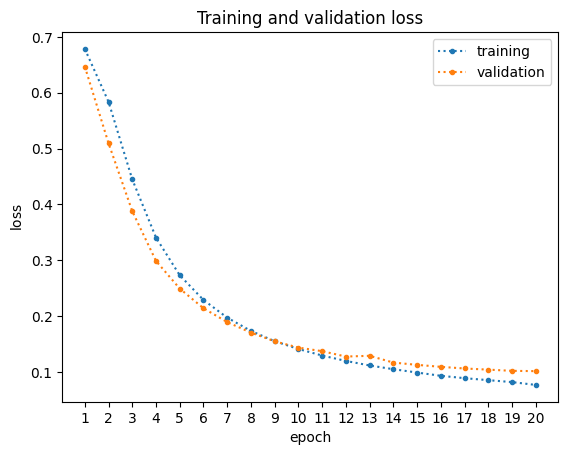

In [39]:
plt.plot(range(1, max(epochs) + 2), history.history['loss'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_loss'], ".:")

plt.title('Training and validation loss')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel(r"$\mathrm{loss}$")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

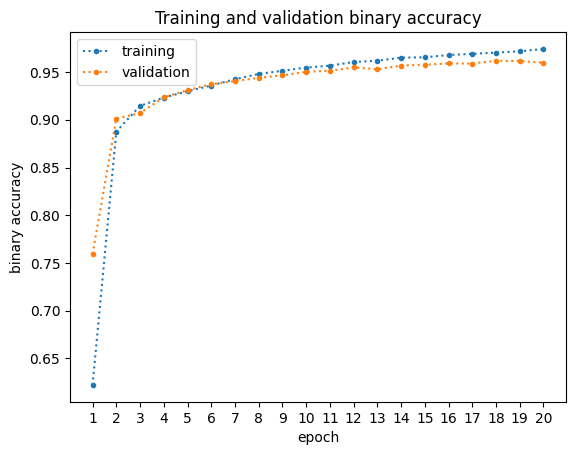

In [41]:
plt.plot(range(1, max(epochs) + 2), history.history['binary_accuracy'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_binary_accuracy'], ".:")

plt.title('Training and validation binary accuracy')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("binary accuracy")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

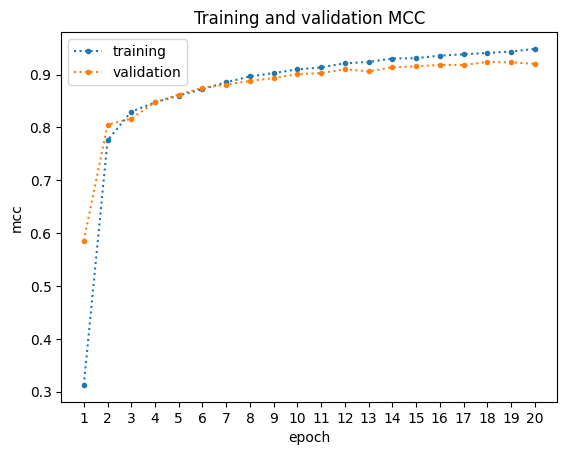

In [42]:
plt.plot(range(1, max(epochs) + 2), history.history['mcc'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_mcc'], ".:")

plt.title('Training and validation MCC')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("mcc")
plt.xlabel("epoch")
plt.xticks(range(1, max(epochs) + 2))
plt.show()

In [ ]:
# model predictions on the test set

In [24]:
y_pred = model.predict(test_text)

277/277 [==============================] - 0s 953us/step


In [25]:
y_pred.shape

(8855, 1)

In [26]:
y_pred > 0.5

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [27]:
evaluation = model.evaluate(x = test_text, y = y_test, return_dict = True)

277/277 [==============================] - 0s 1ms/step - loss: 0.1013 - binary_accuracy: 0.9598 - precision: 0.9430 - recall: 0.9754 - mcc: 0.9201


In [28]:
evaluation.items()

dict_items([('loss', 0.10133900493383408), ('binary_accuracy', 0.9597967267036438), ('precision', 0.9430451393127441), ('recall', 0.9753578901290894), ('mcc', 0.9200799465179443)])

In [29]:
for metric, value in evaluation.items():
    print(f"{metric}: {value:.4f}")

loss: 0.1013
binary_accuracy: 0.9598
precision: 0.9430
recall: 0.9754
mcc: 0.9201
